In [1]:
import pandas as pd
import numpy as np
from dimod import BinaryQuadraticModel
from dwave.system import LeapHybridSampler
import matplotlib.pyplot as plt
import warnings
from collections import Counter
import cirq
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (10,8)

In [2]:
df = pd.read_csv('basket.csv')

In [3]:
df.loc[df.PTS > df['PTS.1'], 'Winner'] = df['Visitor']
df.loc[df.PTS < df['PTS.1'], 'Winner'] = df['Home']

df.loc[df.PTS > df['PTS.1'], 'Loser'] = df['Home']
df.loc[df.PTS < df['PTS.1'], 'Loser'] = df['Visitor']

In [4]:
df['VisitorPPG'] = df.groupby('Visitor')['PTS'].transform(np.mean)
df['HomePPG'] = df.groupby('Home')['PTS.1'].transform(np.mean)

In [5]:
df

,Date,Start (ET),Visitor,PTS,Home,PTS.1,Attend.,Winner,Loser,VisitorPPG,HomePPG
0,"Tue, Dec 22, 2020",7:00p,Golden State Warriors,99,Brooklyn Nets,125,0,Brooklyn Nets,Golden State Warriors,110.750000,127.000000
1,"Tue, Dec 22, 2020",10:00p,Los Angeles Clippers,116,Los Angeles Lakers,109,0,Los Angeles Clippers,Los Angeles Lakers,118.500000,120.250000
2,"Wed, Dec 23, 2020",7:00p,Charlotte Hornets,114,Cleveland Cavaliers,121,300,Cleveland Cavaliers,Charlotte Hornets,116.000000,108.333333
3,"Wed, Dec 23, 2020",7:00p,New York Knicks,107,Indiana Pacers,121,0,Indiana Pacers,New York Knicks,95.000000,114.750000
4,"Wed, Dec 23, 2020",7:00p,Miami Heat,107,Orlando Magic,113,"3,396",Orlando Magic,Miami Heat,107.000000,102.500000
...,...,...,...,...,...,...,...,...,...,...,...
62,"Thu, Dec 31, 2020",6:30p,Philadelphia 76ers,116,Orlando Magic,92,"3,247",Philadelphia 76ers,Orlando Magic,106.333333,102.500000
63,"Thu, Dec 31, 2020",7:00p,Sacramento Kings,119,Houston Rockets,122,"3,247",Houston Rockets,Sacramento Kings,121.500000,122.000000
64,"Thu, Dec 31, 2020",7:30p,New York Knicks,83,Toronto Raptors,100,"3,449",Toronto Raptors,New York Knicks,95.000000,99.500000
65,"Thu, Dec 31, 2020",8:00p,New Orleans Pelicans,113,Oklahoma City Thunder,80,0,New Orleans Pelicans,Oklahoma City Thunder,102.500000,98.666667


In [6]:
sim = {}

for j in range(100):

    games = []

    for i in range(len(df)):
        if df['VisitorPPG'][i] > 0.8*np.exp(np.random.rand(1))*df['HomePPG'][i]:
            games.append(df['Visitor'][i])
        else:
            games.append(df['Home'][i])
            
        cts = Counter(games)
        sim[j] = list(cts.items())

In [7]:
tms = {}

for i in range(100):
    for j in sim[i]:
        try:
            tms[j[0]].append(j[1])
            
        except:
            tms[j[0]] = [j[1]]

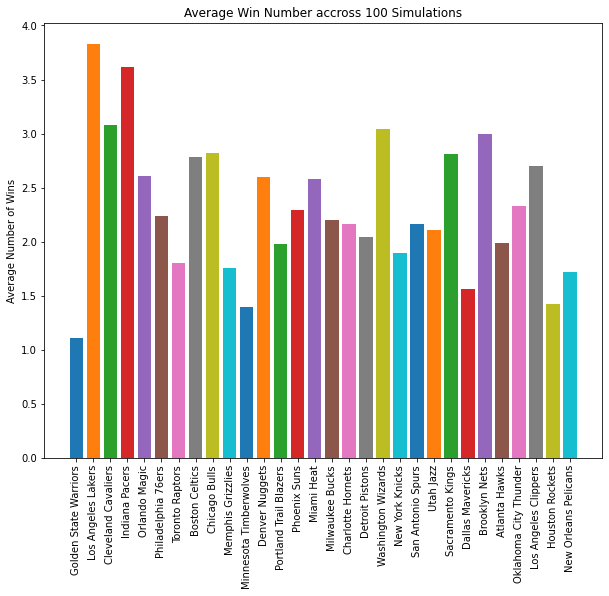

In [8]:
for i, v in tms.items():
    #print(i, np.mean(v))
    plt.bar(i, np.mean(v))
    plt.xticks(rotation = 90)
    plt.title('Average Win Number accross 100 Simulations')
    plt.ylabel('Average Number of Wins')

In [9]:
##actual results####

df.loc[df.Visitor == df.Winner, 'VisitorWin'] = 1
df.loc[df.Home == df.Winner, 'HomeWin'] = 1

gb_wins = df.groupby(['Visitor'])['VisitorWin'].sum() + df.groupby(['Home'])['HomeWin'].sum()
gb_wins

Atlanta Hawks             3.0
Boston Celtics            3.0
Brooklyn Nets             3.0
Charlotte Hornets         2.0
Chicago Bulls             2.0
Cleveland Cavaliers       3.0
Dallas Mavericks          1.0
Denver Nuggets            1.0
Detroit Pistons           0.0
Golden State Warriors     NaN
Houston Rockets           1.0
Indiana Pacers            4.0
Los Angeles Clippers      4.0
Los Angeles Lakers        3.0
Memphis Grizzlies         1.0
Miami Heat                2.0
Milwaukee Bucks           2.0
Minnesota Timberwolves    2.0
New Orleans Pelicans      3.0
New York Knicks           2.0
Oklahoma City Thunder     1.0
Orlando Magic             4.0
Philadelphia 76ers        4.0
Phoenix Suns              4.0
Portland Trail Blazers    2.0
Sacramento Kings          3.0
San Antonio Spurs         2.0
Toronto Raptors           1.0
Utah Jazz                 2.0
Washington Wizards        0.0
dtype: float64

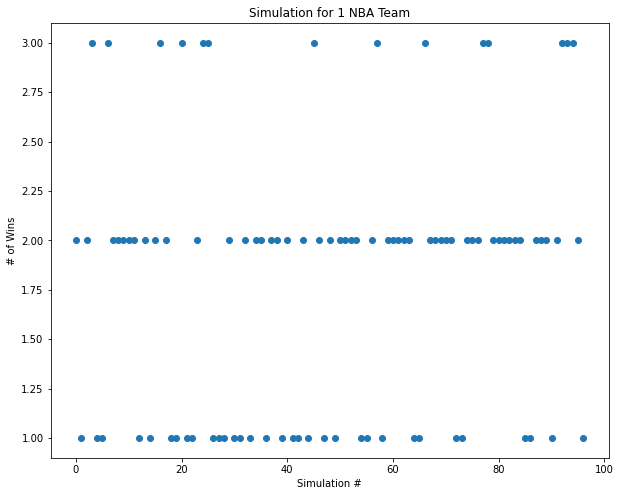

In [11]:
######simulations of one time###

####Looks like we found the lowest energy state is 1 win!####

plt.title('Simulation for 1 NBA Team')
plt.xlabel('Simulation #')
plt.ylabel('# of Wins')
plt.scatter([x for x in range(len(tms['Toronto Raptors']))], tms['Toronto Raptors']);

In [12]:
##########Quantum Algo#################

In [36]:
qubit = cirq.GridQubit(0, 0)

circuit = cirq.Circuit(
    cirq.X(qubit)**0.5,  
    cirq.measure(qubit, key='m')  
)
print("Circuit:")
print(circuit)

Circuit:
(0, 0): ───X^0.5───M('m')───


In [44]:
lst = []

for i in range(100):
    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=5)
    #print(result)
    lst.append(result)
    

In [55]:
dicts ={}

for i in lst:
    try:
        dicts[str(i)].append(1)
    except:
        dicts[str(i)] = [1]

In [ ]:
####the order of the state represents the number of wins in 5 games (ex. 01100 would mean the team won the second and third games and lost the rest)##

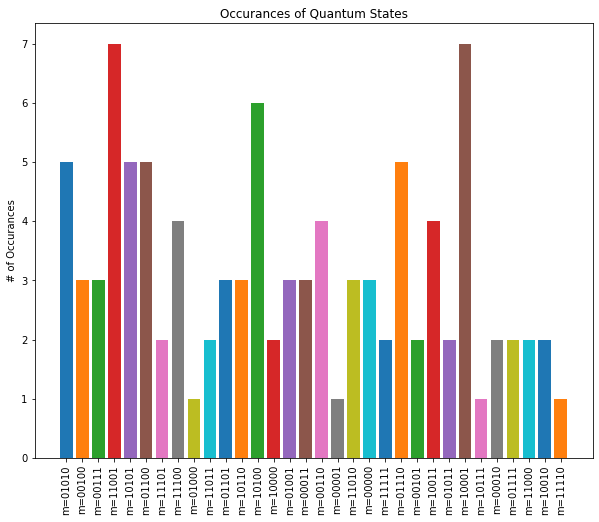

In [64]:
for i,v in dicts.items():
    plt.bar(i, len(v))
    plt.xticks(rotation = 90)
    plt.title('Occurances of Quantum States')
    plt.ylabel('# of Occurances')